# Distribute

Now that we have separated our problem, let's distribute the pieces.

We'll use [Dask.distributed](https://distributed.dask.org/) for distributed computing and [actors](https://distributed.dask.org/en/latest/actors.html).  More on actors [here](https://en.wikipedia.org/wiki/Actor_model).

## Create a Dask cluster

We'll have four workers with 1 thread each that will host different parts of our physical model.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1, memory_limit=1e9)
client

Client Scheduler: tcp://127.0.0.1:61100 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.00 GB


## Space, particles, and random numbers

The following is largely identical to what we did in [02_separation-Copy1.ipynb](02_separation-Copy1.ipynb).

In [2]:
import numpy as np
import pandas as pd

The spatial domain doesn't call anything.  It's identical to the earlier implementation.

In [3]:
class PeriodicSpace:
    def __init__(self, length_x=10, length_y=20):
        self.length_y = length_y
        self.length_x = length_x
        
    def __str__(self):
        return (
            f"PeriodicSpace("
            f"length_x={self.length_x}, "
            f"length_y={self.length_y}"
            f")"
        )

    def apply_periodicity(self, y, x):
        return np.mod(y, self.length_y), np.mod(x, self.length_x)
    
    def get_center(self):
        return self.length_x / 2.0, self.length_y / 2.0

Each particle calls the spatial domain.  In distributed mode, we'll have to make sure that we get the `.result()` from the [`Future` objects](https://docs.python.org/3/library/concurrent.futures.html#future-objects) returned when calling methods on actors.

In [4]:
class Particle:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        x=0, y=0,
        particle_id=0,
        step_length=0.5
    ):
        self.rng = rng
        self.space = space
        self.particle_id = particle_id
        self.x, self.y = x, y
        self.step_length = step_length
        
    def __str__(self):
        return (
            f"Particle("
            f"space={self.space}, "
            f"rng={self.rng}, "
            f"particle_id={self.particle_id}, "
            f"x={self.x}, y={self.y}, "
            f"step_length={self.step_length}"
            ")"
        )

    def move(self):
        # NOTE the .result() calls!
        self.x += self.step_length * self.rng.normal().result()
        self.y += self.step_length * self.rng.normal().result()
        
        self.y, self.x = self.space.apply_periodicity(self.y, self.x).result()

The group of particles calls the spatial domain to learn where the center of the domain is.  Again, we need to obtain the actual return values with `.result()`.

In [5]:
class ParticleGroup:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        number_particles=100,
        step_length=0.5
    ):
        self.steps_done = 0
        self.rng = rng
        self.space = space
        # Note .result() call!
        x, y = space.get_center().result()
        self.particles = [
            Particle(
                particle_id=n, rng=rng, space=space,
                x=x, y=y,
                step_length=step_length
            )
            for n in range(number_particles)
        ]

    def __str__(self):
        return (
            f"ParticleGroup("
            f"rng={self.rng}, "
            f"space={self.space}, "
            f"number_particles={len(self.particles)}"
            ")"
        )
        
    def move(self, N=1, step=1):
        self.steps_done += 1
        [p.move() for p in self.particles]
        
    def positions(self):
        x = np.array([p.x for p in self.particles])
        y = np.array([p.y for p in self.particles])
        return x, y

    def center_of_mass(self):
        x, y = self.positions()
        return x.mean(), y.mean()
    
    def moment_of_inertia(self):
        x, y = self.positions()
        return x.var() + y.var()

    def diagnostics_df(self):
        com = self.center_of_mass()
        mi = self.moment_of_inertia()
        return pd.DataFrame(
            {
                "center_of_mass_x": com[0],
                "center_of_mass_y": com[1],
                "moment_of_inertia": mi
            },
            index=[self.steps_done, ],
        
        )
    
    def positions_df(self):
        x, y = self.positions()
        return pd.DataFrame(
            {"x": x, "y": y},
            index=range(len(x))
        )

## Submit space, rng and group of particles to the cluster

In [6]:
space = client.submit(
    PeriodicSpace,
    length_x=10,
    length_y=20,
    actor=True,
    pure=False
).result()

In [7]:
rng = client.submit(
    np.random.RandomState, actor=True, pure=False
).result()

In [8]:
particles = client.submit(
    ParticleGroup, space=space, rng=rng,
    actor=True, pure=False
).result()

## Plot initial positions

In [9]:
particles.positions_df().result().plot.scatter(x="x", y="y");

## Run the main loop

In [10]:
diags = particles.diagnostics_df().result()
    
for step in range(1, 100):
    particles.move().result()

    diags = diags.append(
        particles.diagnostics_df().result()
    )

## Plot data

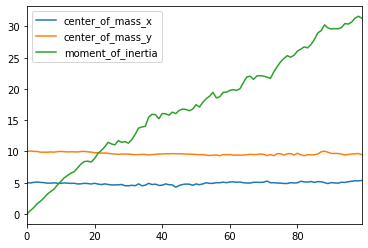

In [11]:
diags.plot();

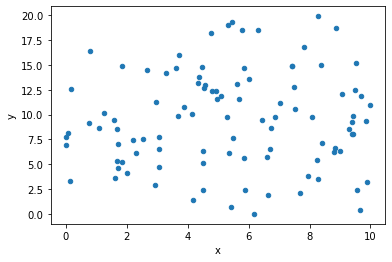

In [12]:
particles.positions_df().result().plot.scatter(x="x", y="y");